# Import

## Lib

In [ ]:
import sys
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from Gems_Wasserstein import *
from sampling import *

import pandas as pd
from torchvision import *
from torchvision.transforms import v2
import torch
import torch.nn as nn
import schedulefree
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy import stats
import gc

import os

# Traitement d'image
from PIL import Image

## Functions

In [2]:
img_folder = '../Data/CelebA/img_align_celeba/img_align_celeba/'
img_names = os.listdir(img_folder)

torch.manual_seed(1)

transform_fct = transforms.v2.Compose([
    transforms.v2.Resize(size=(224, 224), antialias=True),
    transforms.v2.ToDtype(torch.float32, scale=True),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def create_arr_from_img_names(list_img_names):
    list_img = []
    for img_name in list_img_names:
        list_img.append(transform_fct(io.decode_image(img_folder + img_name)/255).reshape(1, -1).numpy())
    arr = np.concatenate(list_img, axis = 0)
    return arr

# Sensitive variable analysis

In [3]:
df = pd.read_csv('../Data/CelebA/list_attr_celeba.csv')
df

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [111]:
for count, column in enumerate(df.columns[1:]):
    DI = DI_fct(df.values[:,1:] > 0, S_index = count, Y_index= 3 - 1)
    print(column, np.round(min(DI, 1/(DI+1e-7)), 2))

5_o_Clock_Shadow 0.81
Arched_Eyebrows 0.61
Attractive 0.0
Bags_Under_Eyes 0.6
Bald 0.06
Bangs 0.86
Big_Lips 0.87
Big_Nose 0.45
Black_Hair 0.99
Blond_Hair 0.69
Blurry 0.23
Brown_Hair 0.75
Bushy_Eyebrows 0.89
Chubby 0.06
Double_Chin 0.08
Eyeglasses 0.17
Goatee 0.43
Gray_Hair 0.06
Heavy_Makeup 0.4
High_Cheekbones 0.75
Male 0.41
Mouth_Slightly_Open 0.96
Mustache 0.33
Narrow_Eyes 0.78
No_Beard 0.52
Oval_Face 0.68
Pale_Skin 0.7
Pointy_Nose 0.63
Receding_Hairline 0.39
Rosy_Cheeks 0.6
Sideburns 0.59
Smiling 0.75
Straight_Hair 0.91
Wavy_Hair 0.66
Wearing_Earrings 0.75
Wearing_Hat 0.39
Wearing_Lipstick 0.37
Wearing_Necklace 0.83
Wearing_Necktie 0.44
Young 0.25


In [7]:
target_name, sensitive_variable_name = 'Attractive', 'Heavy_Makeup'

# Pre-processing

## Creating descriptors

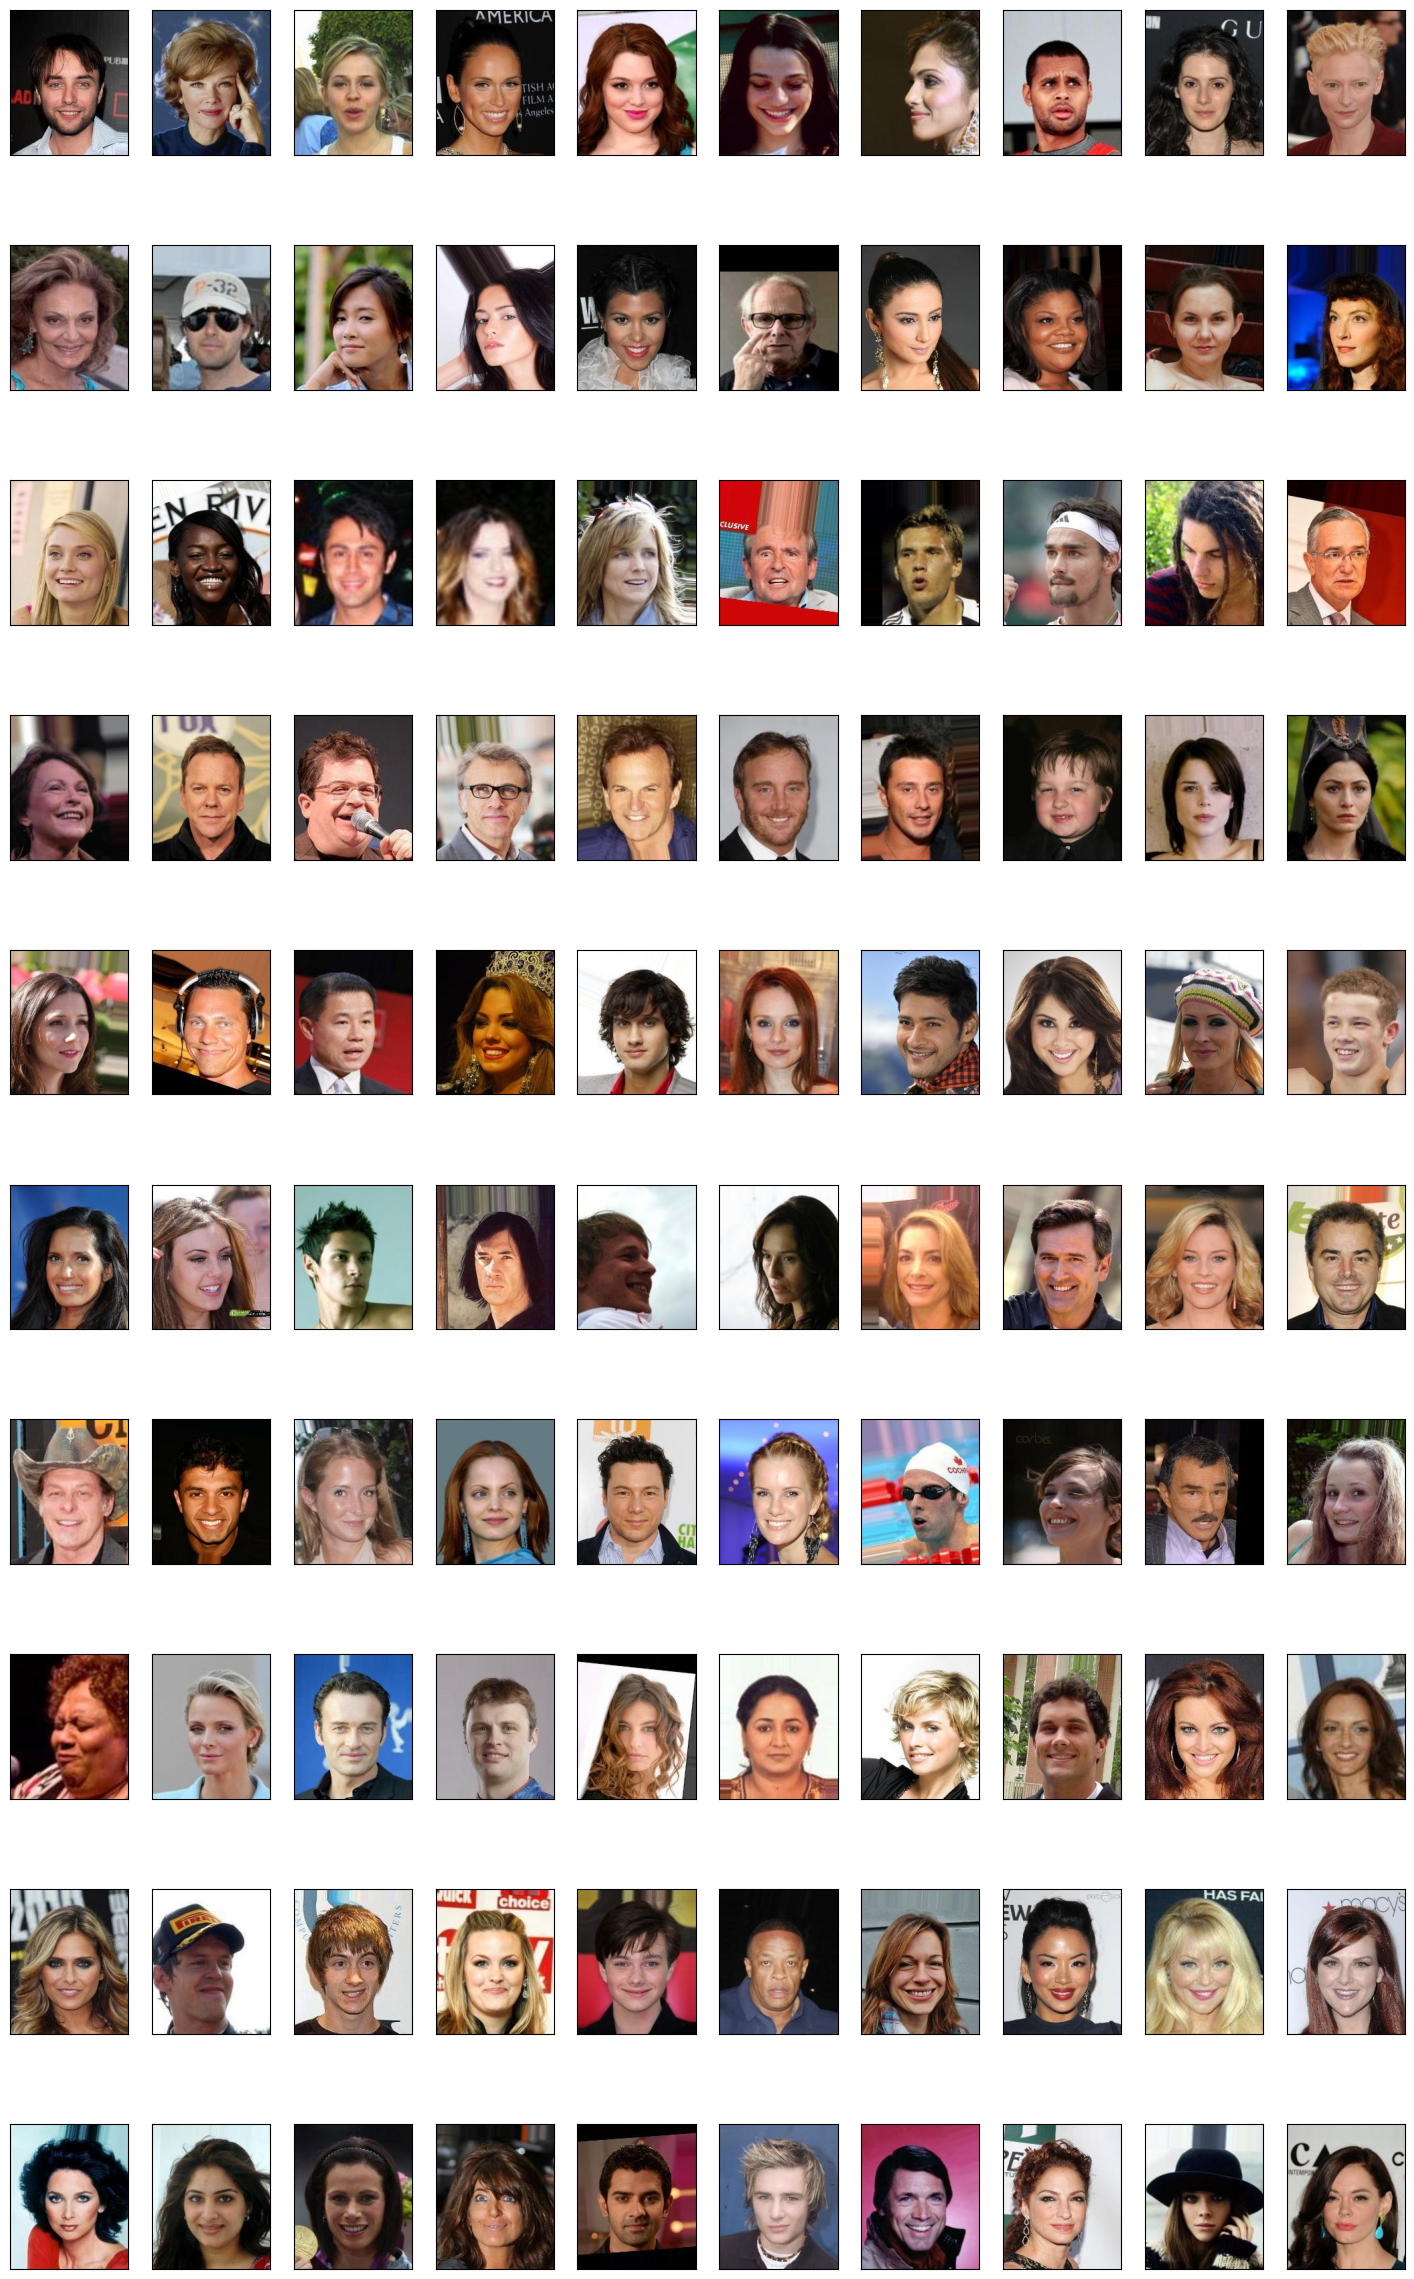

In [510]:
fig, ax = plt.subplots(10,10,figsize = (18, 30))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(io.decode_image(img_folder + img_names[i + j*10]).numpy().transpose(1,2,0))
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [6]:
resnet18    = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
inceptionv3 = models.inception_v3(weights = models.Inception_V3_Weights.IMAGENET1K_V1)
resnet101   = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
transform_18  = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
transform_v3  = models.Inception_V3_Weights.IMAGENET1K_V1.transforms()
transform_101 = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
resnet18.eval()
inceptionv3.eval()
resnet101.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [728]:
emb_size = 1000
arr_descriptor_resnet18    = np.zeros((len(img_names), emb_size))
arr_descriptor_inceptionv3 = np.zeros((len(img_names), emb_size))
arr_descriptor_resnet101   = np.zeros((len(img_names), emb_size))


for count, img_name in tqdm(enumerate(img_names)):
    with torch.no_grad():
        img = io.decode_image(img_folder + img_name).reshape(1, 3, 218, 178)
        img_18, img_v3, img_101 = transform_18(img), transform_v3(img), transform_101(img)
        arr_descriptor_resnet18[count]    = resnet18(img_18).numpy()
        arr_descriptor_inceptionv3[count] = inceptionv3(img_v3).numpy()
        arr_descriptor_resnet101[count]   = resnet101(img_101).numpy()

202599it [9:22:37,  6.00it/s]


In [ ]:
np.save(file = '../Result/CelebA/descriptor_resnet18.npy',
        arr = arr_descriptor_resnet18)
np.save(file = '../Result/CelebA/descriptor_inceptionv3.npy',
        arr = arr_descriptor_inceptionv3)
np.save(file = '../Result/CelebA/descriptor_resnet101.npy',
        arr = arr_descriptor_resnet101)

In [ ]:
'''
In batch : faster with GPU using cuda device
emb_size = 1000
input_size = 224
batch_size = 128
arr_descriptor = np.zeros((len(img_names), emb_size))
for n_batch in tqdm(range(math.ceil(len(img_names)/batch_size))):
    with torch.no_grad():
        list_img = []
        for img_name in img_names[(n_batch * batch_size) : ((n_batch+1) * batch_size)]:
            img = transforms(io.decode_image(img_folder + img_name))
            list_img.append(img.reshape(1,3,input_size,input_size))
        imgs = torch.concatenate(list_img)
        arr_descriptor[(n_batch * batch_size) : ((n_batch+1) * batch_size)] = resnet18(imgs).numpy()
'''

## Neural network predicting Attractiveness

In [ ]:
arr_descriptor_resnet18    = np.load(file = '../Result/CelebA/descriptor_resnet18.npy')
arr_descriptor_inceptionv3 = np.load(file = '../Result/CelebA/descriptor_inceptionv3.npy')
arr_descriptor_resnet101   = np.load(file = '../Result/CelebA/descriptor_resnet101.npy')

we predict on resnet18, the unknown descriptor will be as in FID done by an inceptionv3 model.

In [8]:
test_percentage = 0.1# 0.05
threshold = 0.5
epochs, batch_size = 5, 512
X_resnet18, X_resnet101, X_inceptionv3 = arr_descriptor_resnet18.copy(), arr_descriptor_resnet101.copy(), arr_descriptor_inceptionv3.copy()
X_cr_resnet18 = (X_resnet18 - X_resnet18.mean(axis = 0)) / (X_resnet18.var(axis = 0) ** (1/2))
X_cr_inceptionv3 = (X_inceptionv3 - X_inceptionv3.mean(axis = 0)) / (X_inceptionv3.var(axis = 0) ** (1/2))
X_cr_resnet101 = (X_resnet101 - X_resnet101.mean(axis = 0)) / (X_resnet101.var(axis = 0) ** (1/2))

Y = df[target_name].values
S = df[sensitive_variable_name].values

test_size = int(len(X_resnet18) * test_percentage)
train_size = len(X_resnet18) - test_size
train_size

182340

In [9]:
seed = 1234
indexs = np.arange(len(X_resnet18))
np.random.seed(seed)
np.random.shuffle(indexs)
X_cr_train_resnet18, X_cr_train_resnet101, X_cr_train_inceptionv3 = X_cr_resnet18[indexs[:train_size]], X_cr_resnet101[indexs[:train_size]], X_cr_inceptionv3[indexs[:train_size]]
X_cr_test_resnet18, X_cr_test_resnet101, X_cr_test_inceptionv3 = X_cr_resnet18[indexs[train_size:]], X_cr_resnet101[indexs[train_size:]], X_cr_inceptionv3[indexs[train_size:]]

Y_train, S_train, img_names_train = Y[indexs[:train_size]] > 0, S[indexs[:train_size]] > 0, df['image_id'][indexs[:train_size]].values
Y_test, S_test, img_names_test    =  Y[indexs[train_size:]] > 0, S[indexs[train_size:]] > 0, df['image_id'][indexs[train_size:]].values


X_train_resnet18, X_test_resnet18 = torch.from_numpy(X_cr_train_resnet18.astype(np.float32)), torch.from_numpy(X_cr_test_resnet18.astype(np.float32))
X_train_resnet101, X_test_resnet101 = torch.from_numpy(X_cr_train_resnet101.astype(np.float32)), torch.from_numpy(X_cr_test_resnet101.astype(np.float32))
X_train_inceptionv3, X_test_inceptionv3 = torch.from_numpy(X_cr_train_inceptionv3.astype(np.float32)), torch.from_numpy(X_cr_test_inceptionv3.astype(np.float32))

Y_train, Y_test = torch.from_numpy(Y_train.astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32))

In [10]:
X_train_resnet18.shape, X_test_resnet18.shape

(torch.Size([182340, 1000]), torch.Size([20259, 1000]))

In [ ]:
net_path = '../Result/CelebA/' + 'net_state_dic_resnet18.pt'

model_resnet18 = Network(X_train_resnet18.shape[1], 
                activation_bool = True, 
                n_nodes=1000, 
                n_loop = 4)

optimizer = schedulefree.AdamWScheduleFree(model_resnet18.parameters(), 
                                           lr=0.001) #torch.optim.AdamW(model.parameters(), lr = 0.001)
'''
training_network_threshold(model_resnet18, 
                           optimizer, 
                           threshold  = threshold, 
                           X_train    = X_train_resnet18,
                           Y_train    = Y_train,
                           X_test     = X_test_resnet18,
                           Y_test     = Y_test,
                           epochs     = 2,
                           batch_size = batch_size,
                           )

torch.save(model_resnet18.state_dict(), net_path)
'''
model_resnet18.load_state_dict(torch.load(net_path, weights_only=True))
model_resnet18.eval()

Network(
  (seq): Sequential(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1000, out_features=1000, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1000, out_features=1000, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=1000, out_features=1000, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(i

In [ ]:
net_path_inceptionv3 = '../Result/CelebA/' + 'net_state_dic_inceptionv3.pt'

model_inceptionv3 = Network(X_train_inceptionv3.shape[1], 
                activation_bool = True, 
                n_nodes=1000, 
                n_loop = 4)

optimizer = schedulefree.AdamWScheduleFree(model_inceptionv3.parameters(), 
                                           lr=0.001) #torch.optim.AdamW(model.parameters(), lr = 0.001)
'''
training_network_threshold(model_inceptionv3, 
                           optimizer, 
                           threshold  = threshold, 
                           X_train    = X_train_inceptionv3,
                           Y_train    = Y_train,
                           X_test     = X_test_inceptionv3,
                           Y_test     = Y_test,
                           epochs     = 2,
                           batch_size = batch_size,
                           )

torch.save(model_inceptionv3.state_dict(), net_path_inceptionv3)
'''
model_inceptionv3.load_state_dict(torch.load(net_path_inceptionv3, weights_only=True))
model_inceptionv3.eval()

Network(
  (seq): Sequential(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1000, out_features=1000, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1000, out_features=1000, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=1000, out_features=1000, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(i

In [ ]:
net_path_101 = '../Result/CelebA/' + 'net_state_dic_resnet101.pt'

model_resnet101 = Network(X_train_resnet101.shape[1], 
                activation_bool = True, 
                n_nodes=1000, 
                n_loop = 4)

optimizer = schedulefree.AdamWScheduleFree(model_resnet101.parameters(), 
                                           lr=0.001) #torch.optim.AdamW(model.parameters(), lr = 0.001)
'''
training_network_threshold(model_resnet101, 
                           optimizer, 
                           threshold  = threshold, 
                           X_train    = X_train_resnet101,
                           Y_train    = Y_train,
                           X_test     = X_test_resnet101,
                           Y_test     = Y_test,
                           epochs     = 2,
                           batch_size = batch_size,
                           )

torch.save(model_resnet101.state_dict(), net_path_101)
'''
model_resnet101.load_state_dict(torch.load(net_path_101, weights_only=True))
model_resnet101.eval()

Network(
  (seq): Sequential(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1000, out_features=1000, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1000, out_features=1000, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=1000, out_features=1000, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(i

In [14]:
label = (Y_test > threshold)*1.
proba_resnet18    = model_resnet18(X_test_resnet18.float()).squeeze()
proba_inceptionv3 = model_inceptionv3(X_test_inceptionv3.float()).squeeze()
proba_resnet101   = model_resnet101(X_test_resnet101.float()).squeeze()

prob_threshold_18 = np.quantile(proba_resnet18.detach().numpy(),  1 - ((Y_train > threshold)*1.).mean()) - 1e-7
prob_threshold_101 = np.quantile(proba_resnet101.detach().numpy(),  1 - ((Y_train > threshold)*1.).mean()) - 1e-7
prob_threshold_v3 = np.quantile(proba_inceptionv3.detach().numpy(),  1 - ((Y_train > threshold)*1.).mean()) - 1e-7

pred_18 = ( proba_resnet18 > prob_threshold_18)*1.
pred_101 = ( proba_resnet101 > prob_threshold_101)*1.
pred_v3 = ( proba_inceptionv3 > prob_threshold_v3)*1.

acc_18, acc_101, acc_v3 = ((pred_18 == label)*1.).mean().item(), ((pred_101 == label)*1.).mean().item(), ((pred_v3 == label)*1.).mean().item()
number_expe = 5000
inputs_18, inputs_101, inputs_v3, groups = X_test_resnet18[:number_expe].clone(), X_test_resnet101[:number_expe].clone(), X_test_inceptionv3[:number_expe].clone(), S_test[:number_expe]

DI_18 = (pred_18[:number_expe][groups==0].mean() / pred_18[:number_expe][groups==1].mean()).item()
DI_101 = (pred_101[:number_expe][groups==0].mean() / pred_101[:number_expe][groups==1].mean()).item()
DI_v3 = (pred_v3[:number_expe][groups==0].mean() / pred_v3[:number_expe][groups==1].mean()).item()

print(f'pred mean resnet18: {np.round(pred_18.mean().item(), 3)}, resnet101: {np.round(pred_101.mean().item(), 3)}, inceptionv3: {np.round(pred_v3.mean().item(), 3)}, \n with an accuracy of respectively {np.round(acc_18,3)}, {np.round(acc_101,3)} and {np.round(acc_v3,3)}; \n finally and the Disparate Impact is respectively {np.round(DI_18,3)}, {np.round(DI_101,3)} and {np.round(DI_v3,3)}.')

pred mean resnet18: 0.513, resnet101: 0.513, inceptionv3: 0.513, 
 with an accuracy of respectively 0.793, 0.801 and 0.798; 
 finally and the Disparate Impact is respectively 0.351, 0.351 and 0.344.


In [15]:
img_names_original = img_names_test[:number_expe]
index_original = indexs[train_size:][:number_expe]

# Fair-washing

In [251]:
DI_threshold = 0.40

In [252]:
pred_ori_18, pred_ori_101, pred_ori_v3 = pred_18[:number_expe], pred_101[:number_expe], pred_v3[:number_expe]
arr_start_18 = np.concatenate([inputs_18.float().numpy(), groups.reshape(number_expe, -1), pred_ori_18.reshape(number_expe, -1)], axis = 1)
arr_start_101 = np.concatenate([inputs_101.float().numpy(), groups.reshape(number_expe, -1), pred_ori_101.reshape(number_expe, -1)], axis = 1)
arr_start_v3 = np.concatenate([inputs_v3.float().numpy(), groups.reshape(number_expe, -1), pred_ori_v3.reshape(number_expe, -1)], axis = 1)

In [253]:
new_arr_18, swaps_18, dic_number_swap_done_18, wass_distance_18 = find_sampling_wasserstein_DI(arr = arr_start_18,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [254]:
new_arr_101, swaps_101, dic_number_swap_done_101, wass_distance_101 = find_sampling_wasserstein_DI(arr = arr_start_101,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [255]:
new_arr_v3, swaps_v3, dic_number_swap_done_v3, wass_distance_v3 = find_sampling_wasserstein_DI(arr = arr_start_v3,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [256]:
arr_original_X   = create_arr_from_img_names(img_names_original)
arr_start_18_img = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_18.reshape(number_expe, -1)], axis = 1)
arr_start_101_img = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_101.reshape(number_expe, -1)], axis = 1)
arr_start_v3_img = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_v3.reshape(number_expe, -1)], axis = 1)

In [257]:
new_arr_18_img, swaps_18_img, dic_number_swap_done_18_img, wass_distance_18_img = find_sampling_wasserstein_DI(arr = arr_start_18_img,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [258]:
new_arr_101_img, swaps_101_img, dic_number_swap_done_101_img, wass_distance_101_img = find_sampling_wasserstein_DI(arr = arr_start_101_img,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [259]:
new_arr_v3_img, swaps_v3_img, dic_number_swap_done_v3_img, wass_distance_v3_img = find_sampling_wasserstein_DI(arr = arr_start_v3_img,
                                                                                   S_index = -2,
                                                                                   Y_index = -1,
                                                                                   verbose = False,
                                                                                   threshold = DI_threshold,
                                                                                   )

In [260]:
dic_number_swap_done_18, dic_number_swap_done_101, dic_number_swap_done_18_img

({'Y0S0 -> Y1S0': 121,
  'Y0S0 -> Y0S1': 0,
  'Y1S1 -> Y1S0': 10,
  'Y1S1 -> Y0S1': 0},
 {'Y0S0 -> Y1S0': 86,
  'Y0S0 -> Y0S1': 1,
  'Y1S1 -> Y1S0': 52,
  'Y1S1 -> Y0S1': 0},
 {'Y0S0 -> Y1S0': 124,
  'Y0S0 -> Y0S1': 5,
  'Y1S1 -> Y1S0': 0,
  'Y1S1 -> Y0S1': 0})

In [261]:
img_names_matching_18 = img_names_original.copy()
index_matching_18     = index_original.copy()
for ind_from, ind_to, W_d in swaps_18:
    img_names_matching_18[int(ind_from)] = img_names_matching_18[int(ind_to)]
    index_matching_18[int(ind_from)] = index_matching_18[int(ind_to)]

In [262]:
img_names_matching_101 = img_names_original.copy()
index_matching_101     = index_original.copy()
for ind_from, ind_to, W_d in swaps_101:
    img_names_matching_101[int(ind_from)] = img_names_matching_101[int(ind_to)]
    index_matching_101[int(ind_from)] = index_matching_101[int(ind_to)]

In [263]:
img_names_matching_v3 = img_names_original.copy()
index_matching_v3     = index_original.copy()
for ind_from, ind_to, W_d in swaps_v3:
    img_names_matching_v3[int(ind_from)] = img_names_matching_v3[int(ind_to)]
    index_matching_v3[int(ind_from)] = index_matching_v3[int(ind_to)]

In [264]:
img_names_matching_18_img = img_names_original.copy()
index_matching_18_img     = index_original.copy()
for ind_from, ind_to, W_d in swaps_18_img:
    img_names_matching_18_img[int(ind_from)] = img_names_matching_18_img[int(ind_to)]
    index_matching_18_img[int(ind_from)] = index_matching_18_img[int(ind_to)]

In [265]:
img_names_matching_101_img = img_names_original.copy()
index_matching_101_img     = index_original.copy()
for ind_from, ind_to, W_d in swaps_101_img:
    img_names_matching_101_img[int(ind_from)] = img_names_matching_101_img[int(ind_to)]
    index_matching_101_img[int(ind_from)] = index_matching_101_img[int(ind_to)]

In [266]:
img_names_matching_v3_img = img_names_original.copy()
index_matching_v3_img     = index_original.copy()
for ind_from, ind_to, W_d in swaps_v3_img:
    img_names_matching_v3_img[int(ind_from)] = img_names_matching_v3_img[int(ind_to)]
    index_matching_v3_img[int(ind_from)] = index_matching_v3_img[int(ind_to)]

In [ ]:
((df.loc[index_matching_18][sensitive_variable_name] > 0) - new_arr_18[:,-2]).mean()

In [287]:
total = 0
for para in resnet18.parameters():
    total += para.flatten().shape[0]
total

11689512

# Detecting fraud attempt : Statistical test on X

## Naive method : W on image

In [80]:
iter_precision, threshold_DI = 30, 0.95
verbose = True
max_wass_iter = 1e7
n_sample = 500 #500

In [81]:
arr_original_X    = create_arr_from_img_names(img_names_original)
arr_original_18   = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_18.reshape(number_expe, -1)], axis = 1)
arr_original_101  = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_101.reshape(number_expe, -1)], axis = 1)
arr_original_v3   = np.concatenate([arr_original_X, groups.reshape(number_expe, -1), pred_ori_v3.reshape(number_expe, -1)], axis = 1)

In [ ]:
dic_threshold = {'18'  : {500 : {}, 1000 : {}}, 
                 '101' : {500 : {}, 1000 : {}}, 
                 'v3'  : {500 : {}, 1000 : {}}}

dic_arr_ori   = {'18'  : arr_original_18, 
                 '101' : arr_original_101, 
                 'v3'  : arr_original_v3,}

In [84]:
for model_type in dic_threshold.keys():
    list_W = []
    try:
        W_goal = dic_threshold[model_type][n_sample]['img']
    except:
        for i in range(iter_precision):
            sample = sample_arr(dic_arr_ori[model_type], 
                            n_sample)
            list_W.append(Wasserstein(dic_arr_ori[model_type], sample, numItermax=max_wass_iter))
        W_values = np.array(list_W)
        W_goal = np.mean(W_values) + 1.96 * np.std(W_values)
        dic_threshold[model_type][n_sample]['img'] = W_goal
    print(W_goal)

375.32146734526594
376.05013746849505
375.9497448933356


In [97]:
for model_type in ['18_img', '101_img', 'v3_img']:
    dic_threshold[model_type] =  {500 : {}, 1000 : {}}
    dic_threshold[model_type][n_sample]['img'] = dic_threshold[model_type[:-4]][n_sample]['img']
    dic_arr_ori[model_type]  = dic_arr_ori[model_type[:-4]] 
dic_threshold

{'18': {500: {'img': np.float64(375.32146734526594)}, 1000: {}},
 '101': {500: {'img': np.float64(376.05013746849505)}, 1000: {}},
 'v3': {500: {'img': np.float64(375.9497448933356)}, 1000: {}},
 '18_img': {500: {'img': np.float64(375.32146734526594)}, 1000: {}},
 '101_img': {500: {'img': np.float64(376.05013746849505)}, 1000: {}},
 'v3_img': {500: {'img': np.float64(375.9497448933356)}, 1000: {}}}

In [ ]:
dic_result = {}
for key in dic_threshold:
    dic_result[key] = {500  : {'img' : False, 'resnet18' : False, 'resnet101' : False, 'inceptionv3' : False}, 
                       1000 : {'img' : False, 'resnet18' : False, 'resnet101' : False, 'inceptionv3' : False}}

In [88]:
arr_X_18  = create_arr_from_img_names(img_names_matching_18)
arr_X_101 = create_arr_from_img_names(img_names_matching_101)
arr_X_v3  = create_arr_from_img_names(img_names_matching_v3)
arr_X_18_img  = create_arr_from_img_names(img_names_matching_18_img)
arr_X_101_img = create_arr_from_img_names(img_names_matching_101_img)
arr_X_v3_img  = create_arr_from_img_names(img_names_matching_v3_img)

arr_fair_18   = np.concatenate([arr_X_18, new_arr_18[:,-2].reshape(number_expe, -1), new_arr_18[:,-1].reshape(number_expe, -1)], axis = 1)
arr_fair_101   = np.concatenate([arr_X_101, new_arr_101[:,-2].reshape(number_expe, -1), new_arr_101[:,-1].reshape(number_expe, -1)], axis = 1)
arr_fair_v3   = np.concatenate([arr_X_v3, new_arr_v3[:,-2].reshape(number_expe, -1), new_arr_v3[:,-1].reshape(number_expe, -1)], axis = 1)
arr_fair_18_img   = np.concatenate([arr_X_18_img, new_arr_18_img[:,-2].reshape(number_expe, -1), new_arr_18_img[:,-1].reshape(number_expe, -1)], axis = 1)
arr_fair_101_img   = np.concatenate([arr_X_101_img, new_arr_101_img[:,-2].reshape(number_expe, -1), new_arr_101_img[:,-1].reshape(number_expe, -1)], axis = 1)
arr_fair_v3_img   = np.concatenate([arr_X_v3_img, new_arr_v3_img[:,-2].reshape(number_expe, -1), new_arr_v3_img[:,-1].reshape(number_expe, -1)], axis = 1)

In [89]:
dic_arr_fair   = {'18' : arr_fair_18, '101' : arr_fair_101, 'v3' : arr_fair_v3, '18_img' : arr_fair_18_img, '101_img' : arr_fair_101_img, 'v3_img' : arr_fair_v3_img}

In [90]:
for model_type in dic_arr_fair.keys():
    print(model_type, DI_fct(dic_arr_fair[model_type],  
                S_index = -2, 
                Y_index = -1))

18 0.9503237697073706
101 0.950664061729126
v3 0.9505078314740053
18_img 0.9504140812117663
101_img 0.9505901493368438
v3_img 0.9504904278040661


In [69]:
number_simulation = 100

In [102]:
for model_type in dic_threshold.keys():
    print(model_type)
    for i in range(number_simulation):
        sample = sample_arr(dic_arr_fair[model_type], 
                        n_sample)
        DI = DI_fct(sample, 
                S_index = -2, 
                Y_index = -1)
        if DI >= threshold_DI:

            W_sample = Wasserstein(dic_arr_ori[model_type], sample, numItermax=max_wass_iter)
            print(DI, W_sample)
            if W_sample < dic_threshold[model_type][n_sample]['img']:
                dic_result[model_type][n_sample]['img'] = True
                if verbose:
                    print('found')
                    print(model_type, i, W_sample, '\n')
                break

18
1.120886075949367 377.5915227585278
1.088474025974026 379.7276631490387
0.9977801144993573 379.4392240416756
1.040563687324821 376.24477714455077
1.0613418530351437 378.05628060048366
0.9560463121783876 378.56282538983646
1.0717380837746748 378.6389563907023
0.988048552754435 376.8749762099188
0.989010989010989 377.5086079225474
1.116926723286589 375.41750651908785
1.0103950103950106 374.88005676922035
found
18 18 374.88005676922035 

101
1.0881468376824412 382.5124152918325
1.019584709768759 378.8508094232062
1.1544361243476289 376.505094217895
1.1526595257713084 379.9903371360593
0.9726069559864573 382.36772104326343
0.9988913525498891 381.4742846010378
1.0030573248407644 381.211378171222
1.0011086474501107 378.422414106661
0.9980968577907353 379.0023136848399
0.999574486192077 381.19570772089287
1.019648728847542 379.5117637428079
1.0236154298680562 381.06255200911943
1.0253646163601775 379.28013888179714
1.1585245164192532 380.18232957561645
0.9695264885138303 379.02221685978554

In [86]:
del arr_original_X, arr_original_18, arr_original_101, arr_original_v3, arr_fair_18, arr_fair_101, arr_fair_v3, arr_X_18, arr_X_101, arr_X_v3
gc.collect()

77

## Proposed method : W on descriptor

In [267]:
number_simulation = 50
threshold_DI = DI_threshold

In [268]:
dic_descriptors = {'resnet18'    : arr_descriptor_resnet18,
                   'inceptionv3' : arr_descriptor_inceptionv3,
                   'resnet101'   : arr_descriptor_resnet101}

'''
dic_threshold = {'18'  : {500 : {}, 1000 : {}}, 
                 '101' : {500 : {}, 1000 : {}}, 
                 'v3'  : {500 : {}, 1000 : {}},
                 '18_img'  : {500 : {}, 1000 : {}}, 
                 '101_img' : {500 : {}, 1000 : {}}, 
                 'v3_img'  : {500 : {}, 1000 : {}}}

dic_result = {}
for key in dic_threshold:
    dic_result[key] = {500  : {'img' : False, 'resnet18' : False, 'resnet101' : False, 'inceptionv3' : False}, 
                       1000 : {'img' : False, 'resnet18' : False, 'resnet101' : False, 'inceptionv3' : False}}
'''

for descriptor_name, descriptor in dic_descriptors.items():
    print(descriptor_name)
    X_ori = descriptor[index_original].copy()

    arr_ori_18     = np.concatenate([X_ori, groups.reshape(number_expe, -1), pred_ori_18.reshape(number_expe, -1)], axis = 1)
    arr_ori_101    = np.concatenate([X_ori, groups.reshape(number_expe, -1), pred_ori_101.reshape(number_expe, -1)], axis = 1)
    arr_ori_v3     = np.concatenate([X_ori, groups.reshape(number_expe, -1), pred_ori_v3.reshape(number_expe, -1)], axis = 1)

    dic_ori   = {'18' : arr_ori_18, '101' : arr_ori_101, 'v3' : arr_ori_v3}

    for n_sample in [500, 1000]:
        for model_type in dic_ori.keys():
            try:
                W_goal = dic_threshold[model_type][n_sample][descriptor_name]
            except:
                print(descriptor_name, n_sample, model_type)
                list_W = []
                for i in range(iter_precision):
                    sample = sample_arr(dic_ori[model_type], 
                                        n_sample)
                    list_W.append(Wasserstein(dic_ori[model_type], sample, numItermax=max_wass_iter))
                W_values = np.array(list_W)
                W_goal = np.mean(W_values) + 1.96 * np.std(W_values)
                dic_threshold[model_type][n_sample][descriptor_name] = W_goal
            print(W_goal)

    for n_sample in [500, 1000]:
        for model_type in ['18_img', '101_img', 'v3_img']:
            dic_threshold[model_type][n_sample][descriptor_name] = dic_threshold[model_type[:-4]][n_sample][descriptor_name]
            dic_ori[model_type]  = dic_ori[model_type[:-4]] 

    X_fair_18      = descriptor[index_matching_18].copy()
    X_fair_101     = descriptor[index_matching_101].copy()
    X_fair_v3      = descriptor[index_matching_v3].copy()
    X_fair_18_img  = descriptor[index_matching_18_img].copy()
    X_fair_101_img = descriptor[index_matching_101_img].copy()
    X_fair_v3_img  = descriptor[index_matching_v3_img].copy()

    arr_fair_18       = np.concatenate([X_fair_18,      new_arr_18[:,-2].reshape(number_expe, -1),      new_arr_18[:,-1].reshape(number_expe, -1)],      axis = 1)
    arr_fair_101      = np.concatenate([X_fair_101,     new_arr_101[:,-2].reshape(number_expe, -1),     new_arr_101[:,-1].reshape(number_expe, -1)],     axis = 1)
    arr_fair_v3       = np.concatenate([X_fair_v3,      new_arr_v3[:,-2].reshape(number_expe, -1),      new_arr_v3[:,-1].reshape(number_expe, -1)],      axis = 1)
    arr_fair_18_img   = np.concatenate([X_fair_18_img,  new_arr_18_img[:,-2].reshape(number_expe, -1),  new_arr_18_img[:,-1].reshape(number_expe, -1)],  axis = 1)
    arr_fair_101_img  = np.concatenate([X_fair_101_img, new_arr_101_img[:,-2].reshape(number_expe, -1), new_arr_101_img[:,-1].reshape(number_expe, -1)], axis = 1)
    arr_fair_v3_img  = np.concatenate([X_fair_v3_img,  new_arr_v3_img[:,-2].reshape(number_expe, -1),  new_arr_v3_img[:,-1].reshape(number_expe, -1)],  axis = 1)

    dic_arr_fair   = {'18'     : arr_fair_18,     '101'     : arr_fair_101,     'v3' : arr_fair_v3, 
                      '18_img' : arr_fair_18_img, '101_img' : arr_fair_101_img, 'v3_img' : arr_fair_v3_img}

    for n_sample in [500, 1000]:
        for model_type in dic_threshold.keys():
            if dic_result[model_type][n_sample][descriptor_name] == False:
                print(n_sample, model_type)
                
                for i in range(number_simulation):
                    sample = sample_arr(dic_arr_fair[model_type], 
                                        n_sample)
                    DI = DI_fct(sample, 
                                S_index = -2, 
                                Y_index = -1)
                    if DI >= threshold_DI:

                        W_sample = Wasserstein(dic_ori[model_type], sample, numItermax=max_wass_iter)
                        print(DI, W_sample)
                        if W_sample < dic_threshold[model_type][n_sample][descriptor_name]:
                            dic_result[model_type][n_sample][descriptor_name] = True
                            if verbose:
                                print('found')
                                print(descriptor_name, n_sample, model_type, i, W_sample, '\n')
                            break

resnet18
30.38794739232915
30.37421780072982
30.323740188867124
26.13787836917253
26.091380159973276
26.105040267751573
1000 101
0.41870040159829025 25.973660496955823
found
resnet18 1000 101 1 25.973660496955823 

1000 v3
0.4273909114757921 26.069258700827238
found
resnet18 1000 v3 4 26.069258700827238 

1000 18_img
0.4063150045135209 26.066883714225888
found
resnet18 1000 18_img 4 26.066883714225888 

1000 101_img
0.4298245614035088 25.938387043009
found
resnet18 1000 101_img 5 25.938387043009 

1000 v3_img
0.4113837187441248 26.097561212122752
found
resnet18 1000 v3_img 1 26.097561212122752 

inceptionv3
19.34116290570584
19.344419199020706
19.317129262401064
16.596453239271423
16.580869326757096
16.54927992047039
1000 101
0.413308465317271 16.52179639994996
found
inceptionv3 1000 101 0 16.52179639994996 

1000 v3
0.4002360641665325 16.49131507327867
found
inceptionv3 1000 v3 0 16.49131507327867 

1000 18_img
0.425883285425477 16.538809732323408
found
inceptionv3 1000 18_img 0 16.53

In [167]:
dic_result_copy = dic_result.copy()

0.95

In [150]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,False,False,False,False,False,False,resnet18,20%
0,True,True,True,False,True,False,inceptionv3,10%
1,False,False,False,False,False,False,inceptionv3,20%
0,True,True,True,True,False,False,resnet101,10%
1,False,False,False,False,False,False,resnet101,20%


0.8

In [174]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,False,False,False,False,False,False,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,False,False,False,False,False,False,inceptionv3,20%
0,True,True,True,True,False,False,resnet101,10%
1,False,False,False,False,False,False,resnet101,20%


0.7

In [193]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,False,False,False,False,False,False,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,False,False,False,False,False,False,inceptionv3,20%
0,True,True,True,True,True,True,resnet101,10%
1,False,False,False,False,False,False,resnet101,20%


0.6

In [212]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,True,False,False,False,False,False,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,False,False,False,False,False,False,inceptionv3,20%
0,True,True,True,True,True,True,resnet101,10%
1,False,False,False,False,False,False,resnet101,20%


0.55

In [250]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,True,False,False,False,False,False,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,True,False,False,False,False,False,inceptionv3,20%
0,True,True,True,True,True,True,resnet101,10%
1,True,False,True,False,False,False,resnet101,20%


0.5

In [231]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,True,True,True,True,True,True,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,True,True,True,False,False,False,inceptionv3,20%
0,True,True,True,True,True,True,resnet101,10%
1,True,True,True,False,False,False,resnet101,20%


0.4

In [269]:
dic_dic = {}
list_df = []
for descriptor_name, descriptor in dic_descriptors.items():
    dic_dic[descriptor_name] = {}
    for model_type in dic_threshold.keys():
        dic_dic[descriptor_name][model_type]   = [dic_result[model_type][500][descriptor_name], dic_result[model_type][1000][descriptor_name] ]
    df = pd.DataFrame(dic_dic[descriptor_name])
    df['descriptor_name'] = descriptor_name
    df['sample_size'] = ['10%', '20%']
    list_df.append(df)
pd.concat(list_df)

,18,101,v3,18_img,101_img,v3_img,descriptor_name,sample_size
0,True,True,True,True,True,True,resnet18,10%
1,True,True,True,True,True,True,resnet18,20%
0,True,True,True,True,True,True,inceptionv3,10%
1,True,True,True,True,True,True,inceptionv3,20%
0,True,True,True,True,True,True,resnet101,10%
1,True,True,True,True,True,True,resnet101,20%


## Highest achievable DI with this criterion

In [555]:
number_simulation = 100

class Found(Exception): pass
W_goal = dic_threshold['resnet18']
try:
    for threshold_DI in tqdm(np.arange(0.75, 0.55, -0.05)):
        print(threshold_DI)
        new_arr, swaps, dic_number_swap_done, wass_distance = find_sampling_wasserstein_DI(arr = arr_start,
                                                                                   S_index = -2, #dic_col_name_index[dic_file[file_obj]['S_variable_name']],
                                                                                   Y_index = -1, #dic_col_name_index[dic_file[file_obj]['target_name']],
                                                                                   verbose = False,
                                                                                   threshold = threshold_DI,
                                                                                   )
        img_names_matching = img_names_original.copy()
        index_matching     = index_original.copy()
        for ind_from, ind_to, W_d in swaps:
            img_names_matching[int(ind_from)] = img_names_matching[int(ind_to)]
            index_matching[int(ind_from)] = index_matching[int(ind_to)]

        X_resnet101_matching = arr_descriptor_resnet101[index_matching].copy()
        arr_matching_resnet101 = np.concatenate([X_resnet101_matching, new_arr[:,-2].reshape(number_expe, -1), new_arr[:,-1].reshape(number_expe, -1)], axis = 1)

        for i in range(number_simulation):
            sample = sample_arr(arr_matching_resnet101, 
                                n_sample)
            DI = DI_fct(sample, 
                        S_index = -2, 
                        Y_index = -1)
            if DI > threshold_DI:

                W_sample = Wasserstein(arr_original_resnet101, 
                                    sample, 
                                    numItermax=max_wass_iter)
                if W_sample < W_goal:
                    raise Found
except Found:
    print(i, np.round(threshold_DI, 3), W_sample)




  0%|          | 0/4 [00:00<?, ?it/s]

0.75


 25%|██▌       | 1/4 [00:49<02:27, 49.00s/it]

0.7


 25%|██▌       | 1/4 [01:29<04:29, 89.86s/it]

75 0.7 2.4458994967031393


In [556]:
DI

np.float64(0.710708782742681)